In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [10]:
df =pd.read_csv('data_akbilgic.csv')
df.head()

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [11]:
df =df.drop('date', axis=1)

In [12]:
train_size = int(df.shape[0]*0.8)
df_train = df[:train_size]
df_test = df[train_size:]

df_train = df_train.values
df_test =df_test.values

feat= df.values

In [13]:
# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_stock_batch(batch_size, n_steps, feat, n_features):
    t_min = 0
    t_max = feat.shape[0]
  
    # The inputs will be formed by 8 sequences taken from
    # 7 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU]
    x = np.zeros((batch_size,n_steps,n_features))
    
    # We want to predict the returns of the Istambul stock
    # taken into consideration the previous n_steps days
    y = np.zeros((batch_size,n_steps))

    # We chose batch_size random points from time series x-axis

    starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)    
    #print(starting_points)
    #print(feat.shape)
    
    # We create the batches for x using all time series (8) between t and t+n_steps]
    for i, sp in enumerate(starting_points):
        x[i] = feat[sp: sp+n_steps]
        y[i] = feat[sp+1:sp+n_steps+1, 1]    
    # We create the batches for y using only one time series between t+1 and t+n_steps+1
    
    #Save on x and y the time series data sequence and the prediction sequence

    return x,y

x,y =  next_stock_batch(batch_size=32, n_steps=10, feat=feat, n_features=9)
print(x.shape)

(32, 10, 9)


In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, seq_len):
        super(). __init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_size =batch_size
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first =True)

        self.fc1 = nn.Linear(self.batch_size*self.hidden_size, 10)
        self.fc2 = nn.Linear(10, self.batch_size*self.seq_len)

    def forward(self, x):
        h_0=torch.zeros((self.num_layers, self.batch_size, self.hidden_size ))
        c_0=torch.zeros((self.num_layers, self.batch_size, self.hidden_size ))

        lstm_out, (h_n, c_n) = self.lstm(x,(h_0,c_0))
        last_hidden = h_n[-1]
        #print(last_hidden.shape)
        #ans torch.Size([10, 32, 5]), n_steps=10, batch_size=32, hidden_size=5

        x = F.relu(last_hidden.flatten()) # added this line, you can activate also the last hidden layer, for better performance
        #print(x.shape)
        #ans: torch.Size([1600]) if you multiply that ([10, 32, 5]) you will get

        x = F.relu(self.fc1(x))
        # error in here: x = F.relu(self.fc1(x)),  self.fc1=nn.Linear(self.batch_size*self.hidden_size, 1024)
        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1600 and 160x1024)
        out = self.fc2(x)
        return out

model = LSTM(input_size=9, hidden_size=5, num_layers=10, batch_size=32, seq_len=10)
nx= torch.from_numpy(x).float()
#print(nx.shape)
#ans torch.Size([32, 10, 9]), batch_size=32, n_steps=10, feat=feat, n_features=9
pred=model(nx)


In [15]:
# We initialize our RNN model to pass it to the optimizer

model = LSTM(df.shape[1],5, 10, 32, 10)

# What would be an adecuate loss function?
criterion = nn.MSELoss()

# optimizer to apply the gradients
optimizer = torch.optim.Adam(model.parameters(),lr=0.001 )

MSE: 0.03504864498972893
MSE: 0.019334690645337105
MSE: 0.006604543421417475
MSE: 0.0022303410805761814
MSE: 0.0011081616394221783
MSE: 0.0006641888758167624
MSE: 0.0005223475745879114
MSE: 0.00048250198597088456
MSE: 0.0004956505144946277
MSE: 0.0004473178123589605


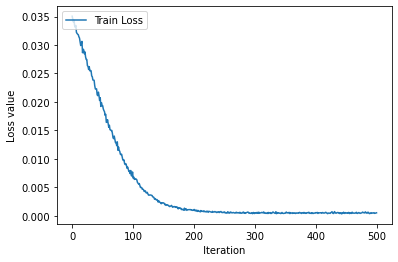

In [16]:
#number of batches we will go through
batch_size= 32
#how many squence there will be in a bacth
n_iterations = 500
#after how many operations we will print information
printing_gap = 50

#We will store the loss values here to plot them
train_loss = []

for iter in range(n_iterations):
    #Get a batch

    X_train, y_train = next_stock_batch(batch_size=32, n_steps=10, feat=df_train, n_features=9)

    #make into tensor

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    #make them into torch variables in float format

    #Reset the gradients
    
    optimizer.zero_grad()
    #Get the outputs
    pred=model(X_train)
    #detach the hidden state
    
    #compute the loss
    loss = criterion(pred, y_train.flatten())
    #compute the gradients
    loss.backward()
    #Apply the gradients
    optimizer.step()

    #Append the loss value

    train_loss.append(loss.item())

    if iter % printing_gap == 0:
        print(f'MSE: {loss.item()}')
        #Print the information


plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()